## Downloading Data 

In [ ]:
#Download Data For Glove Embedding
!wget http://nlp.stanford.edu/data/glove.6B.zip
!unzip glove*.zip

In [ ]:
# Installing mittens for fine tuning Glove Embedding
!pip install -U mittens

In [ ]:
!pip install transformers

     |████████████████████████████████| 2.3MB 6.6MB/s 
     |████████████████████████████████| 3.3MB 42.1MB/s 
     |████████████████████████████████| 901kB 39.5MB/s 


In [ ]:
!pip install bert-embedding

## Loading required libraries

In [ ]:
import re
import numpy as np
import pandas as pd
from tqdm import tqdm
import matplotlib.pyplot as plt


import nltk
from nltk.tag import StanfordNERTagger
from nltk.corpus import stopwords 
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer 

import spacy 
from spacy import displacy

from gensim.models import Word2Vec
from gensim.models.fasttext import FastText
from mittens import GloVe, Mittens

from sklearn.datasets import fetch_20newsgroups

from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Dense, Bidirectional, LSTM, Dropout, BatchNormalization
from keras.layers.embeddings import Embedding
from tensorflow.keras.utils import to_categorical

from tensorflow.keras import Model,Input
from tensorflow.keras.layers import LSTM,Embedding,Dense
from tensorflow.keras.layers import TimeDistributed, SpatialDropout1D,Bidirectional

import keras
import pickle

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, precision_recall_curve,plot_confusion_matrix,confusion_matrix

from collections import Counter
from mittens import GloVe, Mittens
from sklearn.feature_extraction import stop_words
from sklearn.feature_extraction.text import CountVectorizer

nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('punkt')

import warnings
warnings.filterwarnings('ignore')

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.feature_extraction.stop_words module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.feature_extraction.text. Anything that cannot be imported from sklearn.feature_extraction.text is now part of the private API.
  warnings.warn(message, FutureWarning)


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


## Required Functions

In [ ]:
def decontracted(phrase):
    ''' 
      Function used to decontact the words in the phrase
      Input: phrase
      Output: decontracted phrase
    '''
    phrase = re.sub(r"\S+@\S+"," ",phrase)
    phrase = re.sub(r"won't", "will not", phrase)
    phrase = re.sub(r"can\'t", "can not", phrase)
    phrase = re.sub(r"n\'t", " not", phrase)
    phrase = re.sub(r"\'re", " are", phrase)
    phrase = re.sub(r"\'s", " is", phrase)
    phrase = re.sub(r"\'d", " would", phrase)
    phrase = re.sub(r"\'ll", " will", phrase)
    phrase = re.sub(r"\'t", " not", phrase)
    phrase = re.sub(r"\'ve", " have", phrase)
    phrase = re.sub(r"\'m", " am", phrase)
    phrase = re.sub('[^A-Za-z.]+', ' ', phrase)
    return phrase

## Downloading the 20newsgroup dataset from sklearn

In [ ]:
twenty_data = fetch_20newsgroups(subset='all', shuffle=False, remove=('headers', 'quotes'))

In [ ]:
twenty_data.data[402]

'\n\n\nHere in the UK, the bandwidth restriction apparently only apply to \nlocal lines.. ie those used by the average domestic client. Private\nlines which are run from the local exchange to the leasing client are \nusually capable of a higher bandwidth if the exchange is digital.\n\nDon\'t quote me on that..... But I think I remember a BT engineer \nsaying something to that effect when I was doing some work\nshadowing a few years ago.\n\nByeeeee !\n\n\nChris ;-)\n\n  +====================================================================+\n  |Name : Mr Chris Smith       |     Twang on that \'ole guitar !       |\n  |Addrs: scst83@uk.ac.liv.csc |                                       |\n  |Uni  : Liverpool University |Quest: To build more and more hardware |\n  |Dgree: Computer Science     |                                       |\n  +====================================================================+\n\n "What ever the sun may be, it is certainly not a ball of flaming gas!"\n  -- D.H

## Cleaning the data

In [ ]:
data = []
for i in tqdm(range(len(twenty_data.data))):
   temp = twenty_data.data[i]
   temp = decontracted(temp) 
   temp = temp.split('.')
   data.extend(temp)

100%|██████████| 18846/18846 [00:02<00:00, 6835.82it/s]


In [ ]:
max_len = 0
for i in data:
  if((len(i) < 20) or (len(i) > 500)):
    data.remove(i)

# Extracting NER uisng Spacy and creating  annotated documents for NER detection.

In [ ]:
nlp = spacy.load("en_core_web_sm")

In [ ]:
ent_spacy = []
lab_spacy = []
unique_ent = []
for text in tqdm(data):

  temp1 = []
  temp2 = []

  doc = nlp(text)

  for token in doc:
    temp1.append(str(token))
    if token.ent_type_ == '':
      ent = 'O'
    else: 
      ent = str(token.ent_type_)
    
    if ent not in unique_ent:
      unique_ent.append(ent)

    temp2.append(ent)

  lab_spacy.append(temp2[1:])
  ent_spacy.append(temp1[1:])
 


100%|██████████| 236391/236391 [3:12:53<00:00, 20.43it/s]


In [ ]:
print("Number of unique NER Tag ", len(unique_ent))

Number of unique NER Tag  19


In [ ]:
dict = {'Sentence': ent_spacy, 'NER_TAG': lab_spacy} 
     
df = pd.DataFrame(dict)
df.to_csv('annotated_data.csv')

In [ ]:
with open("ent_spacy.txt", "wb") as fp:
    pickle.dump(ent_spacy, fp)

In [ ]:
with open("lab_spacy.txt", "wb") as fp:
    pickle.dump(lab_spacy, fp)

In [ ]:
with open("lab_spacy.txt", "rb") as fp:
      lab_spacy, = pickle.load(fp)

In [ ]:
with open("ent_spacy.txt", "rb") as fp:
      ent_spacy = pickle.load(fp)

# Word2Vec Embedding and LSTM based NER Model

In [ ]:
data_u = ent_spacy
tags_list = lab_spacy

In [ ]:
# Fine Tune w2v model on data set
w2v_model=Word2Vec(data_u,min_count=1,size=50, workers=4)

In [ ]:
w2v_words = list(w2v_model.wv.vocab)
print("number of words that occured minimum 1 times ",len(w2v_words))
print("sample words ", w2v_words[:20])

number of words that occured minimum 1 times  19835
sample words  ['morgan', 'and', 'guzman', 'will', 'have', 'era', 'is', 'run', 'higher', 'than', 'last', 'year', 'the', 'cubs', 'be', 'idiots', 'not', 'pitch', 'harkey', 'as']


In [ ]:
# Finding length of longest review
max_length = 128

In [ ]:
# Tokenizing Data
token = Tokenizer()
token.fit_on_texts(data_u)
vocab_size = len(token.word_index) + 1
encoded = token.texts_to_sequences(data)
padded_data = pad_sequences(encoded, maxlen=max_length, padding='post')

vocab_size = len(token.word_index) + 1

In [ ]:
#Creating Embedding matrix using trained word to vec model
embedding_matrix = np.zeros((vocab_size, 50))
for word, i in token.word_index.items():
    try: 
      embedding_vector = w2v_model.wv[word]
    except:
      embedding_vector  = None

    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector

In [ ]:
# Creating Tag Mapping and Encoding the Tags
tags=list(set(unique_ent))
print(tags)
num_tags=len(tags)
print("Number of Tags ",num_tags)

tags_map={tag:i for i,tag in enumerate(tags)}
print("Tags Map ",tags_map)

['LOC', 'PRODUCT', 'LANGUAGE', 'DATE', 'EVENT', 'ORDINAL', 'CARDINAL', 'PERSON', 'LAW', 'WORK_OF_ART', 'O', 'NORP', 'ORG', 'GPE', 'TIME', 'QUANTITY', 'MONEY', 'PERCENT', 'FAC']
Number of Tags  19
Tags Map  {'LOC': 0, 'PRODUCT': 1, 'LANGUAGE': 2, 'DATE': 3, 'EVENT': 4, 'ORDINAL': 5, 'CARDINAL': 6, 'PERSON': 7, 'LAW': 8, 'WORK_OF_ART': 9, 'O': 10, 'NORP': 11, 'ORG': 12, 'GPE': 13, 'TIME': 14, 'QUANTITY': 15, 'MONEY': 16, 'PERCENT': 17, 'FAC': 18}


In [ ]:
# Creating Reverse tag Map
reverse_tag_map={v: k for k, v in tags_map.items()}

In [ ]:
# Encoding taggs
encoded_tags=[[tags_map[w] for w in tag] for tag in tags_list]
print("First Sentence ",data[0])
print('First Sentence Original Tags ',tags_list[0])
print("First Sentence Encoded Tags ",encoded_tags[0])
print("Is length of Original Tags and Encoded Tags same ",len(tags_list[0])==len(encoded_tags[0]))
print("Length of Tags for First Sentence ",len(encoded_tags[0]))

First Sentence   morgan and guzman will have era is run higher than last year and the cubs will be idiots and not pitch harkey as much as hibbard
First Sentence Original Tags  ['PERSON', 'O', 'ORG', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'DATE', 'DATE', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']
First Sentence Encoded Tags  [7, 10, 12, 10, 10, 10, 10, 10, 10, 10, 3, 3, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10]
Is length of Original Tags and Encoded Tags same  True
Length of Tags for First Sentence  26


In [ ]:
# Add padding to encoded text
padded_encoded_tags=pad_sequences(maxlen=max_length,sequences=encoded_tags,padding="post",value=tags_map['O'])

In [ ]:
padded_encoded_tags.shape

In [ ]:
target= np.array([np.array(to_categorical(i,num_classes = num_tags)) for i in  padded_encoded_tags])
print("Shape of Labels  after converting to Categorical",target.shape)

Shape of Labels  after converting to Categorical (10000, 128, 19)


In [ ]:
# Train and test split in 8:2 ratio
x_train, x_test, y_train, y_test = train_test_split(padded_data, target, test_size=0.2)

Creating LSTM Model

In [ ]:

lstm_units=128
max_len=128
embedding_dim=128

input_word = Input(shape = (max_len))
model = Embedding(vocab_size, 50, input_length=max_length, weights=[embedding_matrix], trainable=True)(input_word)

model = LSTM(units=embedding_dim,return_sequences=True)(model)
model = Dropout(0.2)(model)
model = BatchNormalization()(model)
out = TimeDistributed(Dense(num_tags,activation = 'softmax'))(model)
model = Model(input_word,out)

model.compile(optimizer = 'adam',loss = 'categorical_crossentropy',metrics = ['accuracy'])
model.summary()

Model: "model_12"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_16 (InputLayer)        [(None, 128)]             0         
_________________________________________________________________
embedding_22 (Embedding)     (None, 128, 50)           834200    
_________________________________________________________________
lstm_29 (LSTM)               (None, 128, 128)          91648     
_________________________________________________________________
dropout_13 (Dropout)         (None, 128, 128)          0         
_________________________________________________________________
batch_normalization_12 (Batc (None, 128, 128)          512       
_________________________________________________________________
time_distributed_13 (TimeDis (None, 128, 19)           2451      
Total params: 928,811
Trainable params: 928,555
Non-trainable params: 256
__________________________________________________

In [ ]:
## Fit train data
history = model.fit(x_train,y_train,validation_split=0.2,batch_size=32, epochs =10)

Epoch 1/10
200/200 [==============================] - 37s 176ms/step - loss: 1.9199 - accuracy: 0.8195 - val_loss: 0.1066 - val_accuracy: 0.9874
Epoch 2/10
200/200 [==============================] - 35s 174ms/step - loss: 0.0632 - accuracy: 0.9894 - val_loss: 0.0881 - val_accuracy: 0.9874
Epoch 3/10
200/200 [==============================] - 35s 175ms/step - loss: 0.0407 - accuracy: 0.9913 - val_loss: 0.0628 - val_accuracy: 0.9875
Epoch 4/10
200/200 [==============================] - 35s 175ms/step - loss: 0.0282 - accuracy: 0.9935 - val_loss: 0.0432 - val_accuracy: 0.9904
Epoch 5/10
200/200 [==============================] - 35s 176ms/step - loss: 0.0219 - accuracy: 0.9945 - val_loss: 0.0433 - val_accuracy: 0.9904
Epoch 6/10
200/200 [==============================] - 35s 175ms/step - loss: 0.0194 - accuracy: 0.9951 - val_loss: 0.0458 - val_accuracy: 0.9897
Epoch 7/10
200/200 [==============================] - 35s 175ms/step - loss: 0.0168 - accuracy: 0.9955 - val_loss: 0.0492 - val_ac

In [ ]:
t_loss = history.history['loss']
v_loss = history.history['val_loss']
accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']

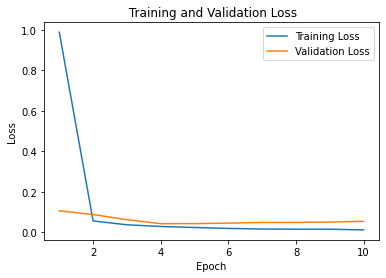

In [ ]:

x = [i for i in range(1,11)]

plt.title(" Training and Validation Loss")
plt.xlabel('Epoch')
plt.ylabel('Loss')

plt.plot(x,t_loss,label='Training Loss')
plt.plot(x,v_loss,label='Validation Loss')

plt.legend()
plt.show()

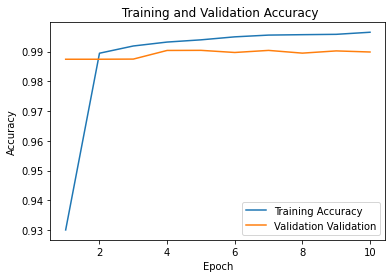

In [ ]:
x = [i for i in range(1,11)]

plt.title(" Training and Validation Accuracy")

plt.xlabel('Epoch')
plt.ylabel('Accuracy')

plt.plot(x,accuracy,label='Training Accuracy')
plt.plot(x,val_accuracy,label='Validation Validation')

plt.legend()
plt.show()

**Evaluating the Model**

To evaluate the model, we will have to remove the padded portion and identify the accuracy. For this, for every test data, let us create a dataframe wuth the tokens and the actual and predicted value - and use it to calculate the metrics

In [ ]:
def evaluatePredictions(test_data,preds,actual_preds):
    print("Shape of Test Data Array",test_data.shape)
    y_actual=np.argmax(np.array(actual_preds),axis=2)
    y_pred=np.argmax(preds,axis=2)
    num_test_data=test_data.shape[0]
    print("Number of Test Data Points ",num_test_data)
    data=pd.DataFrame()
    df_list=[]
    for i in range(num_test_data):
        test_str=list(test_data[i])
        df=pd.DataFrame()
        df['test_tokens']=test_str
        df['tokens']=df['test_tokens'].apply(lambda x:token.index_word[x] if x!=0 else '<PAD>')
        df['actual_target_index']=list(y_actual[i])
        df['pred_target_index']=list(y_pred[i])
        df['actual_target_tag']=df['actual_target_index'].apply(lambda x:reverse_tag_map[x])
        df['pred_target_tag']=df['pred_target_index'].apply(lambda x:reverse_tag_map[x])
        df['id']=i+1
        df_list.append(df)
    data=pd.concat(df_list)
    pred_data=data[data['tokens']!='<PAD>']
    accuracy=pred_data[pred_data['actual_target_tag']==pred_data['pred_target_tag']].shape[0]/pred_data.shape[0]
    
    
    return pred_data,accuracy

In [ ]:
y_pred = model.predict(x_test)

In [ ]:
pred_data,accuracy=evaluatePredictions(x_test,y_pred,y_test)

Shape of Test Data Array (2000, 128)
Number of Test Data Points  2000


In [ ]:
print("Accuracy on test data is : ",round(accuracy,2))

Accuracy on test data is :  0.93


In [ ]:
y_pred=pred_data['pred_target_tag'].tolist()
y_actual=pred_data['actual_target_tag'].tolist()

In [ ]:
print(classification_report(y_actual,y_pred))

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

    CARDINAL       0.67      0.56      0.61       177
        DATE       0.72      0.31      0.44       249
       EVENT       0.00      0.00      0.00        19
         FAC       0.27      0.08      0.12        52
         GPE       0.65      0.47      0.55       289
    LANGUAGE       0.00      0.00      0.00         0
         LAW       0.44      0.19      0.26        37
         LOC       0.65      0.50      0.57       110
       MONEY       0.00      0.00      0.00        11
        NORP       0.77      0.64      0.69       181
           O       0.95      0.98      0.96     33941
     ORDINAL       0.73      0.88      0.80        58
         ORG       0.43      0.32      0.37      1074
      PERSON       0.73      0.40      0.52       836
     PRODUCT       0.18      0.02      0.03       156
    QUANTITY       0.00      0.00      0.00        21
        TIME       0.52      0.32      0.39        47
 WORK_OF_ART       0.56    

In [ ]:
pred_data[pred_data['actual_target_tag']=='LOC']

,test_tokens,tokens,actual_target_index,pred_target_index,actual_target_tag,pred_target_tag,id
10,2,the,0,10,LOC,O,132
11,763,southern,0,0,LOC,LOC,132
12,1190,hemisphere,0,0,LOC,LOC,132
3,247,south,0,0,LOC,LOC,412
4,482,georgia,0,0,LOC,LOC,412
...,...,...,...,...,...,...,...
9,7882,xmnblinkrate,0,1,LOC,PRODUCT,1954
30,247,south,0,0,LOC,LOC,1974
31,482,georgia,0,0,LOC,LOC,1974
32,385,island,0,0,LOC,LOC,1974


# Glove Embedding and LSTM based NER Model

In [ ]:
data_u = ent_spacy
tags_list = lab_spacy

In [ ]:
# Reading glove embedding file and creating embedding dictionary
# Using 50 dimension embedding vector
initial_embeddings = dict()
f = open('./glove.6B.50d.txt')
for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    initial_embeddings[word] = coefs
f.close()

In [ ]:
#Finding words not in vocabolary
oov = []
for i in data:
  for j in i :
    if ((j not in initial_embeddings.keys()) and (j not in oov)):
      oov.append(j)
corp_vocab = list(set(oov))

cv = CountVectorizer(ngram_range=(1,1), vocabulary=corp_vocab)
X = cv.fit_transform(data)
Xc = (X.T * X)
Xc.setdiag(0)
coocc_ar = Xc.toarray()


/usr/local/lib/python3.7/dist-packages/scipy/sparse/_index.py:126: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


In [ ]:
mittens_model = Mittens(n=50, max_iter=500)
new_embeddings = mittens_model.fit(
    coocc_ar,
    vocab=corp_vocab,
    initial_embedding_dict= initial_embeddings)

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


In [ ]:
max_length = 128

In [ ]:
# Tokenizing Data
token = Tokenizer()
token.fit_on_texts(data_u)
vocab_size = len(token.word_index) + 1
encoded = token.texts_to_sequences(data_u)
padded_data = pad_sequences(encoded, maxlen=128, padding='post')

In [ ]:
embeddings_index = initial_embeddings
for i in range(len(oov)):
  embeddings_index[oov[i]] = new_embeddings[i]

In [ ]:
#Creating Embedding matrix using Glove Vector
embedding_matrix = np.zeros((vocab_size, 50))
for word, i in token.word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector

In [ ]:
# Creating Tag Mapping and Encoding the Tags
tags=list(set(unique_ent))
print(tags)
num_tags=len(tags)
print("Number of Tags ",num_tags)

tags_map={tag:i for i,tag in enumerate(tags)}
print("Tags Map ",tags_map)

['TIME', 'PERCENT', 'WORK_OF_ART', 'PRODUCT', 'LOC', 'ORDINAL', 'DATE', 'CARDINAL', 'QUANTITY', 'FAC', 'PERSON', 'ORG', 'EVENT', 'NORP', 'GPE', 'LAW', 'LANGUAGE', 'O', 'MONEY']
Number of Tags  19
Tags Map  {'TIME': 0, 'PERCENT': 1, 'WORK_OF_ART': 2, 'PRODUCT': 3, 'LOC': 4, 'ORDINAL': 5, 'DATE': 6, 'CARDINAL': 7, 'QUANTITY': 8, 'FAC': 9, 'PERSON': 10, 'ORG': 11, 'EVENT': 12, 'NORP': 13, 'GPE': 14, 'LAW': 15, 'LANGUAGE': 16, 'O': 17, 'MONEY': 18}


In [ ]:
# Creating Reverse tag Map
reverse_tag_map={v: k for k, v in tags_map.items()}

In [ ]:
# Encoding taggs
encoded_tags=[[tags_map[w] for w in tag] for tag in tags_list]
print("First Sentence ",data[0])
print('First Sentence Original Tags ',tags_list[0])
print("First Sentence Encoded Tags ",encoded_tags[0])
print("Is length of Original Tags and Encoded Tags same ",len(tags_list[0])==len(encoded_tags[0]))
print("Length of Tags for First Sentence ",len(encoded_tags[0]))

First Sentence   morgan and guzman will have era is run higher than last year and the cubs will be idiots and not pitch harkey as much as hibbard
First Sentence Original Tags  ['PERSON', 'O', 'ORG', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'DATE', 'DATE', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']
First Sentence Encoded Tags  [10, 17, 11, 17, 17, 17, 17, 17, 17, 17, 6, 6, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17]
Is length of Original Tags and Encoded Tags same  True
Length of Tags for First Sentence  26


In [ ]:
# Add padding to encoded text
padded_encoded_tags=pad_sequences(maxlen=max_length,sequences=encoded_tags,padding="post",value=tags_map['O'])

In [ ]:
padded_encoded_tags.shape

In [ ]:
target= np.array([np.array(to_categorical(i,num_classes = num_tags)) for i in  padded_encoded_tags])
print("Shape of Labels  after converting to Categorical",target.shape)

Shape of Labels  after converting to Categorical (5000, 128, 19)


In [ ]:
# Train and test split in 8:2 ratio
x_train, x_test, y_train, y_test = train_test_split(padded_data, target, test_size=0.2)

Creating LSTM Model

In [ ]:

lstm_units=128
max_len=128
embedding_dim=128

input_word = Input(shape = (max_len))
model = Embedding(vocab_size, 50, input_length=max_length, weights=[embedding_matrix], trainable=True)(input_word)

model = LSTM(units=embedding_dim,return_sequences=True)(model)
out = TimeDistributed(Dense(num_tags,activation = 'softmax'))(model)
model = Model(input_word,out)

model.compile(optimizer = 'adam',loss = 'categorical_crossentropy',metrics = ['accuracy'])
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 128)]             0         
_________________________________________________________________
embedding (Embedding)        (None, 128, 50)           533350    
_________________________________________________________________
lstm (LSTM)                  (None, 128, 128)          91648     
_________________________________________________________________
time_distributed (TimeDistri (None, 128, 19)           2451      
Total params: 627,449
Trainable params: 627,449
Non-trainable params: 0
_________________________________________________________________


In [ ]:
## Fit train data
history = model.fit(x_train,y_train,validation_split=0.2,batch_size=32, epochs =10)

Train on 3200 samples, validate on 800 samples
Epoch 1/10
3200/3200 [==============================] - ETA: 0s - loss: 0.3743 - accuracy: 0.9743

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:2325: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  warnings.warn('`Model.state_updates` will be removed in a future version. '


3200/3200 [==============================] - 20s 6ms/sample - loss: 0.3743 - accuracy: 0.9743 - val_loss: 0.0836 - val_accuracy: 0.9875
Epoch 2/10
3200/3200 [==============================] - 19s 6ms/sample - loss: 0.0722 - accuracy: 0.9874 - val_loss: 0.0620 - val_accuracy: 0.9876
Epoch 3/10
3200/3200 [==============================] - 19s 6ms/sample - loss: 0.0557 - accuracy: 0.9877 - val_loss: 0.0519 - val_accuracy: 0.9879
Epoch 4/10
3200/3200 [==============================] - 19s 6ms/sample - loss: 0.0471 - accuracy: 0.9885 - val_loss: 0.0461 - val_accuracy: 0.9889
Epoch 5/10
3200/3200 [==============================] - 19s 6ms/sample - loss: 0.0415 - accuracy: 0.9897 - val_loss: 0.0422 - val_accuracy: 0.9896
Epoch 6/10
3200/3200 [==============================] - 19s 6ms/sample - loss: 0.0374 - accuracy: 0.9905 - val_loss: 0.0406 - val_accuracy: 0.9898
Epoch 7/10
3200/3200 [==============================] - 19s 6ms/sample - loss: 0.0343 - accuracy: 0.9911 - val_loss: 0.0387 - val

In [ ]:
t_loss = history.history['loss']
v_loss = history.history['val_loss']
accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']

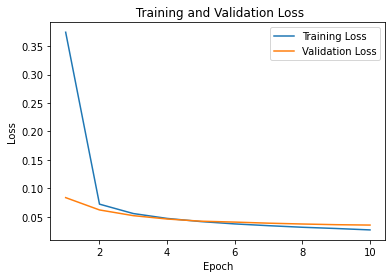

In [ ]:

x = [i for i in range(1,11)]

plt.title(" Training and Validation Loss")
plt.xlabel('Epoch')
plt.ylabel('Loss')

plt.plot(x,t_loss,label='Training Loss')
plt.plot(x,v_loss,label='Validation Loss')

plt.legend()
plt.show()

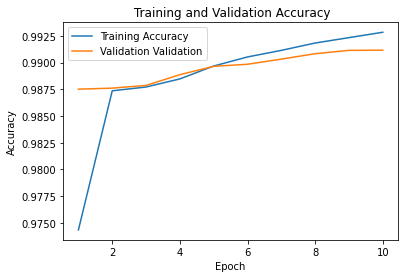

In [ ]:
x = [i for i in range(1,11)]

plt.title(" Training and Validation Accuracy")

plt.xlabel('Epoch')
plt.ylabel('Accuracy')

plt.plot(x,accuracy,label='Training Accuracy')
plt.plot(x,val_accuracy,label='Validation Validation')

plt.legend()
plt.show()

**Evaluating the Model**

To evaluate the model, we will have to remove the padded portion and identify the accuracy. For this, for every test data, let us create a dataframe wuth the tokens and the actual and predicted value - and use it to calculate the metrics

In [ ]:
def evaluatePredictions(test_data,preds,actual_preds):
    print("Shape of Test Data Array",test_data.shape)
    y_actual=np.argmax(np.array(actual_preds),axis=2)
    y_pred=np.argmax(preds,axis=2)
    num_test_data=test_data.shape[0]
    print("Number of Test Data Points ",num_test_data)
    data=pd.DataFrame()
    df_list=[]
    for i in range(num_test_data):
        test_str=list(test_data[i])
        df=pd.DataFrame()
        df['test_tokens']=test_str
        df['tokens']=df['test_tokens'].apply(lambda x:token.index_word[x] if x!=0 else '<PAD>')
        df['actual_target_index']=list(y_actual[i])
        df['pred_target_index']=list(y_pred[i])
        df['actual_target_tag']=df['actual_target_index'].apply(lambda x:reverse_tag_map[x])
        df['pred_target_tag']=df['pred_target_index'].apply(lambda x:reverse_tag_map[x])
        df['id']=i+1
        df_list.append(df)
    data=pd.concat(df_list)
    pred_data=data[data['tokens']!='<PAD>']
    accuracy=pred_data[pred_data['actual_target_tag']==pred_data['pred_target_tag']].shape[0]/pred_data.shape[0]
    
    
    return pred_data,accuracy

In [ ]:
y_pred = model.predict(x_test)

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:2325: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  warnings.warn('`Model.state_updates` will be removed in a future version. '


In [ ]:
pred_data,accuracy=evaluatePredictions(x_test,y_pred,y_test)

Shape of Test Data Array (1000, 128)
Number of Test Data Points  1000


In [ ]:
print("Accuracy on test data is : ",round(accuracy,2))

Accuracy on test data is :  0.93


In [ ]:
y_pred=pred_data['pred_target_tag'].tolist()
y_actual=pred_data['actual_target_tag'].tolist()

In [ ]:
print(classification_report(y_actual,y_pred))

              precision    recall  f1-score   support

    CARDINAL       0.68      0.63      0.66        95
        DATE       0.64      0.53      0.58       136
       EVENT       0.00      0.00      0.00        15
         FAC       0.00      0.00      0.00        20
         GPE       0.63      0.61      0.62       122
    LANGUAGE       0.00      0.00      0.00         1
         LAW       0.00      0.00      0.00        17
         LOC       0.68      0.55      0.61        58
       MONEY       0.00      0.00      0.00         9
        NORP       0.77      0.82      0.79        68
           O       0.96      0.98      0.97     15067
     ORDINAL       0.89      0.89      0.89        37
         ORG       0.50      0.36      0.42       513
     PERCENT       0.00      0.00      0.00         0
      PERSON       0.62      0.56      0.59       328
     PRODUCT       0.00      0.00      0.00        21
    QUANTITY       0.00      0.00      0.00         5
        TIME       0.00    

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
pred_data[pred_data['actual_target_tag']=='LOC']

,test_tokens,tokens,actual_target_index,pred_target_index,actual_target_tag,pred_target_tag,id
5,1685,latin,4,14,LOC,GPE,50
6,456,america,4,14,LOC,GPE,50
0,813,earth,4,17,LOC,O,54
12,1,the,4,17,LOC,O,75
13,132,south,4,4,LOC,LOC,75
14,333,atlantic,4,4,LOC,LOC,75
13,920,northern,4,4,LOC,LOC,92
14,557,hemisphere,4,4,LOC,LOC,92
13,1,the,4,17,LOC,O,97
14,132,south,4,4,LOC,LOC,97


# Fast Text Embedding and LSTM based NER Model

In [ ]:
data_u = ent_spacy
tags_list = lab_spacy

In [ ]:
# Defining values for parameters
embedding_size = 50
window_size = 5
min_word = 5
down_sampling = 1e-2

fast_Text_model = FastText(data_u,
                      size=embedding_size,
                      window=window_size,
                      min_count=min_word,
                      sample=down_sampling,
                      workers = 4,
                      sg=1,
                      iter=100)

In [ ]:
fast_text_words = list(fast_Text_model.wv.vocab)
print("number of words ",len(fast_text_words))
print("sample words ", fast_text_words[:20])

number of words  2248
sample words  ['and', 'will', 'have', 'is', 'run', 'higher', 'than', 'last', 'year', 'the', 'be', 'not', 'as', 'much', 'good', 'i', 'think', 'he', 'a', 'This']


In [ ]:
# Finding length of longest review
max_length = 128

In [ ]:
# Tokenizing Data
token = Tokenizer()
token.fit_on_texts(data_u)
vocab_size = len(token.word_index) + 1
encoded = token.texts_to_sequences(data)
padded_data = pad_sequences(encoded, maxlen=max_length, padding='post')

vocab_size = len(token.word_index) + 1

In [ ]:
#Creating Embedding matrix using trained word to vec model
embedding_matrix = np.zeros((vocab_size, 50))
for word, i in token.word_index.items():
    try: 
      embedding_vector = fast_Text_model.wv[word]
    except:
      embedding_vector  = None

    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector

In [ ]:
# Creating Tag Mapping and Encoding the Tags
tags=list(set(unique_ent))
print(tags)
num_tags=len(tags)
print("Number of Tags ",num_tags)

tags_map={tag:i for i,tag in enumerate(tags)}
print("Tags Map ",tags_map)

['TIME', 'PERCENT', 'WORK_OF_ART', 'PRODUCT', 'LOC', 'ORDINAL', 'DATE', 'CARDINAL', 'QUANTITY', 'FAC', 'PERSON', 'ORG', 'EVENT', 'NORP', 'GPE', 'LAW', 'LANGUAGE', 'O', 'MONEY']
Number of Tags  19
Tags Map  {'TIME': 0, 'PERCENT': 1, 'WORK_OF_ART': 2, 'PRODUCT': 3, 'LOC': 4, 'ORDINAL': 5, 'DATE': 6, 'CARDINAL': 7, 'QUANTITY': 8, 'FAC': 9, 'PERSON': 10, 'ORG': 11, 'EVENT': 12, 'NORP': 13, 'GPE': 14, 'LAW': 15, 'LANGUAGE': 16, 'O': 17, 'MONEY': 18}


In [ ]:
# Creating Reverse tag Map
reverse_tag_map={v: k for k, v in tags_map.items()}

In [ ]:
# Encoding taggs
encoded_tags=[[tags_map[w] for w in tag] for tag in tags_list]
print("First Sentence ",data[0])
print('First Sentence Original Tags ',tags_list[0])
print("First Sentence Encoded Tags ",encoded_tags[0])
print("Is length of Original Tags and Encoded Tags same ",len(tags_list[0])==len(encoded_tags[0]))
print("Length of Tags for First Sentence ",len(encoded_tags[0]))

First Sentence   morgan and guzman will have era is run higher than last year and the cubs will be idiots and not pitch harkey as much as hibbard
First Sentence Original Tags  ['PERSON', 'O', 'ORG', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'DATE', 'DATE', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']
First Sentence Encoded Tags  [10, 17, 11, 17, 17, 17, 17, 17, 17, 17, 6, 6, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17]
Is length of Original Tags and Encoded Tags same  True
Length of Tags for First Sentence  26


In [ ]:
# Add padding to encoded text
padded_encoded_tags=pad_sequences(maxlen=max_length,sequences=encoded_tags,padding="post",value=tags_map['O'])

In [ ]:
padded_encoded_tags.shape

In [ ]:
target= np.array([np.array(to_categorical(i,num_classes = num_tags)) for i in  padded_encoded_tags])
print("Shape of Labels  after converting to Categorical",target.shape)

Shape of Labels  after converting to Categorical (5000, 128, 19)


In [ ]:
# Train and test split in 8:2 ratio
x_train, x_test, y_train, y_test = train_test_split(padded_data, target, test_size=0.2)

Creating LSTM Model

In [ ]:

lstm_units=128
max_len=128
embedding_dim=128

input_word = Input(shape = (max_len))
model = Embedding(vocab_size, 50, input_length=max_length, weights=[embedding_matrix], trainable=True)(input_word)

model = LSTM(units=embedding_dim,return_sequences=True)(model)
model = Dropout(0.2)(model)
model = BatchNormalization()(model)
out = TimeDistributed(Dense(num_tags,activation = 'softmax'))(model)
model = Model(input_word,out)

model.compile(optimizer = 'adam',loss = 'categorical_crossentropy',metrics = ['accuracy'])
model.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 128)]             0         
_________________________________________________________________
embedding_1 (Embedding)      (None, 128, 50)           533350    
_________________________________________________________________
lstm_1 (LSTM)                (None, 128, 128)          91648     
_________________________________________________________________
dropout (Dropout)            (None, 128, 128)          0         
_________________________________________________________________
batch_normalization (BatchNo (None, 128, 128)          512       
_________________________________________________________________
time_distributed_1 (TimeDist (None, 128, 19)           2451      
Total params: 627,961
Trainable params: 627,705
Non-trainable params: 256
___________________________________________________

In [ ]:
## Fit train data
history = model.fit(x_train,y_train,validation_split=0.2,batch_size=32, epochs =10)

Train on 3200 samples, validate on 800 samples
Epoch 1/10
3200/3200 [==============================] - ETA: 0s - loss: 1.9340 - accuracy: 0.8629

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:2325: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  warnings.warn('`Model.state_updates` will be removed in a future version. '


3200/3200 [==============================] - 22s 7ms/sample - loss: 1.9340 - accuracy: 0.8629 - val_loss: 0.4413 - val_accuracy: 0.9868
Epoch 2/10
3200/3200 [==============================] - 21s 7ms/sample - loss: 0.1983 - accuracy: 0.9834 - val_loss: 0.1033 - val_accuracy: 0.9876
Epoch 3/10
3200/3200 [==============================] - 21s 7ms/sample - loss: 0.0780 - accuracy: 0.9876 - val_loss: 0.0927 - val_accuracy: 0.9878
Epoch 4/10
3200/3200 [==============================] - 21s 7ms/sample - loss: 0.0595 - accuracy: 0.9885 - val_loss: 0.0890 - val_accuracy: 0.9878
Epoch 5/10
3200/3200 [==============================] - 21s 7ms/sample - loss: 0.0505 - accuracy: 0.9894 - val_loss: 0.0796 - val_accuracy: 0.9878
Epoch 6/10
3200/3200 [==============================] - 21s 7ms/sample - loss: 0.0453 - accuracy: 0.9898 - val_loss: 0.0651 - val_accuracy: 0.9879
Epoch 7/10
3200/3200 [==============================] - 21s 7ms/sample - loss: 0.0409 - accuracy: 0.9905 - val_loss: 0.0544 - val

In [ ]:
t_loss = history.history['loss']
v_loss = history.history['val_loss']
accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']

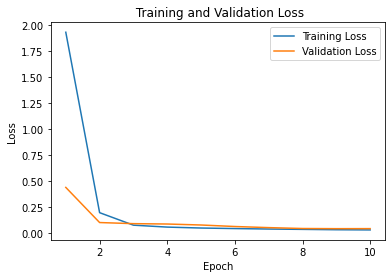

In [ ]:

x = [i for i in range(1,11)]

plt.title(" Training and Validation Loss")
plt.xlabel('Epoch')
plt.ylabel('Loss')

plt.plot(x,t_loss,label='Training Loss')
plt.plot(x,v_loss,label='Validation Loss')

plt.legend()
plt.show()

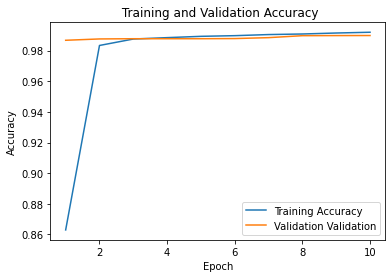

In [ ]:
x = [i for i in range(1,11)]

plt.title(" Training and Validation Accuracy")

plt.xlabel('Epoch')
plt.ylabel('Accuracy')

plt.plot(x,accuracy,label='Training Accuracy')
plt.plot(x,val_accuracy,label='Validation Validation')

plt.legend()
plt.show()

**Evaluating the Model**

To evaluate the model, we will have to remove the padded portion and identify the accuracy. For this, for every test data, let us create a dataframe wuth the tokens and the actual and predicted value - and use it to calculate the metrics

In [ ]:
def evaluatePredictions(test_data,preds,actual_preds):
    print("Shape of Test Data Array",test_data.shape)
    y_actual=np.argmax(np.array(actual_preds),axis=2)
    y_pred=np.argmax(preds,axis=2)
    num_test_data=test_data.shape[0]
    print("Number of Test Data Points ",num_test_data)
    data=pd.DataFrame()
    df_list=[]
    for i in range(num_test_data):
        test_str=list(test_data[i])
        df=pd.DataFrame()
        df['test_tokens']=test_str
        df['tokens']=df['test_tokens'].apply(lambda x:token.index_word[x] if x!=0 else '<PAD>')
        df['actual_target_index']=list(y_actual[i])
        df['pred_target_index']=list(y_pred[i])
        df['actual_target_tag']=df['actual_target_index'].apply(lambda x:reverse_tag_map[x])
        df['pred_target_tag']=df['pred_target_index'].apply(lambda x:reverse_tag_map[x])
        df['id']=i+1
        df_list.append(df)
    data=pd.concat(df_list)
    pred_data=data[data['tokens']!='<PAD>']
    accuracy=pred_data[pred_data['actual_target_tag']==pred_data['pred_target_tag']].shape[0]/pred_data.shape[0]
    
    
    return pred_data,accuracy

In [ ]:
y_pred = model.predict(x_test)

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:2325: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  warnings.warn('`Model.state_updates` will be removed in a future version. '


In [ ]:
pred_data,accuracy=evaluatePredictions(x_test,y_pred,y_test)

Shape of Test Data Array (1000, 128)
Number of Test Data Points  1000


In [ ]:
print("Accuracy on test data is : ",round(accuracy,2))

Accuracy on test data is :  0.93


In [ ]:
y_pred=pred_data['pred_target_tag'].tolist()
y_actual=pred_data['actual_target_tag'].tolist()

In [ ]:
print(classification_report(y_actual,y_pred))

              precision    recall  f1-score   support

    CARDINAL       0.70      0.32      0.44        94
        DATE       0.73      0.37      0.49       189
       EVENT       1.00      0.20      0.33        10
         FAC       0.00      0.00      0.00        27
         GPE       0.73      0.45      0.55       101
    LANGUAGE       0.00      0.00      0.00         2
         LAW       0.00      0.00      0.00         5
         LOC       0.98      0.56      0.71        73
       MONEY       0.00      0.00      0.00        11
        NORP       0.82      0.54      0.65        78
           O       0.94      0.99      0.97     15719
     ORDINAL       0.83      0.73      0.78        26
         ORG       0.46      0.16      0.23       463
      PERSON       0.59      0.35      0.44       382
     PRODUCT       0.00      0.00      0.00        27
    QUANTITY       0.00      0.00      0.00         6
        TIME       0.73      0.24      0.36        34
 WORK_OF_ART       0.67    

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
pred_data[pred_data['actual_target_tag']=='LOC']

,test_tokens,tokens,actual_target_index,pred_target_index,actual_target_tag,pred_target_tag,id
10,132,south,4,4,LOC,LOC,31
11,255,georgia,4,4,LOC,LOC,31
12,214,island,4,4,LOC,LOC,31
12,5710,orient,4,17,LOC,O,67
0,1,the,4,17,LOC,O,107
...,...,...,...,...,...,...,...
13,920,northern,4,17,LOC,O,955
14,557,hemisphere,4,4,LOC,LOC,955
5,1,the,4,17,LOC,O,965
6,670,third,4,5,LOC,ORDINAL,965


# BERT Embedding and LSTM based NER *Model*

In [ ]:
from bert_embedding import BertEmbedding
bert_embedding= BertEmbedding()

In [ ]:
data_u = ent_spacy
tags_list = lab_spacy

In [ ]:
# Finding length of longest review
max_length = 128

In [ ]:
# Tokenizing Data
token = Tokenizer()
token.fit_on_texts(data_u)
vocab_size = len(token.word_index) + 1
encoded = token.texts_to_sequences(data)
padded_data = pad_sequences(encoded, maxlen=max_length, padding='post')

vocab_size = len(token.word_index) + 1

In [ ]:
#Creating Embedding matrix 
embedding_matrix = np.zeros((vocab_size, 768))
for word, i in tqdm(token.word_index.items()):
    try:
      temp =  bert_embedding([word])
      embedding_vector = temp[0][1][0]
    except:
      embedding_vector  = None

    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector

100%|██████████| 3637/3637 [18:48<00:00,  3.22it/s]


In [ ]:
# Creating Tag Mapping and Encoding the Tags
tags=list(set(unique_ent))
print(tags)
num_tags=len(tags)
print("Number of Tags ",num_tags)

tags_map={tag:i for i,tag in enumerate(tags)}
print("Tags Map ",tags_map)

['CARDINAL', 'TIME', 'NORP', 'ORG', 'DATE', 'O', 'PERSON', 'PRODUCT', 'LOC', 'ORDINAL', 'MONEY', 'WORK_OF_ART', 'EVENT', 'FAC', 'QUANTITY', 'LANGUAGE', 'LAW', 'GPE']
Number of Tags  18
Tags Map  {'CARDINAL': 0, 'TIME': 1, 'NORP': 2, 'ORG': 3, 'DATE': 4, 'O': 5, 'PERSON': 6, 'PRODUCT': 7, 'LOC': 8, 'ORDINAL': 9, 'MONEY': 10, 'WORK_OF_ART': 11, 'EVENT': 12, 'FAC': 13, 'QUANTITY': 14, 'LANGUAGE': 15, 'LAW': 16, 'GPE': 17}


In [ ]:
# Creating Reverse tag Map
reverse_tag_map={v: k for k, v in tags_map.items()}

In [ ]:
# Encoding taggs
encoded_tags=[[tags_map[w] for w in tag] for tag in tags_list]
print("First Sentence ",data[0])
print('First Sentence Original Tags ',tags_list[0])
print("First Sentence Encoded Tags ",encoded_tags[0])
print("Is length of Original Tags and Encoded Tags same ",len(tags_list[0])==len(encoded_tags[0]))
print("Length of Tags for First Sentence ",len(encoded_tags[0]))

First Sentence   morgan and guzman will have era is run higher than last year and the cubs will be idiots and not pitch harkey as much as hibbard
First Sentence Original Tags  ['PERSON', 'O', 'ORG', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'DATE', 'DATE', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']
First Sentence Encoded Tags  [6, 5, 3, 5, 5, 5, 5, 5, 5, 5, 4, 4, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5]
Is length of Original Tags and Encoded Tags same  True
Length of Tags for First Sentence  26


In [ ]:
# Add padding to encoded text
padded_encoded_tags=pad_sequences(maxlen=max_length,sequences=encoded_tags,padding="post",value=tags_map['O'])

In [ ]:
padded_encoded_tags.shape

In [ ]:
target= np.array([np.array(to_categorical(i,num_classes = num_tags)) for i in  padded_encoded_tags])
print("Shape of Labels  after converting to Categorical",target.shape)

Shape of Labels  after converting to Categorical (1000, 128, 18)


In [ ]:
# Train and test split in 8:2 ratio
x_train, x_test, y_train, y_test = train_test_split(padded_data, target, test_size=0.2)

Creating LSTM Model

In [ ]:

lstm_units=128
max_len=128
embedding_dim=128

input_word = Input(shape = (max_len))
model = Embedding(vocab_size, 768, input_length=max_length, weights=[embedding_matrix], trainable=True)(input_word)

model = LSTM(units=embedding_dim,return_sequences=True)(model)
model = Dropout(0.2)(model)
model = BatchNormalization()(model)
out = TimeDistributed(Dense(num_tags,activation = 'softmax'))(model)
model = Model(input_word,out)

model.compile(optimizer = 'adam',loss = 'categorical_crossentropy',metrics = ['accuracy'])
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 128)]             0         
_________________________________________________________________
embedding_1 (Embedding)      (None, 128, 768)          2793984   
_________________________________________________________________
lstm (LSTM)                  (None, 128, 128)          459264    
_________________________________________________________________
dropout (Dropout)            (None, 128, 128)          0         
_________________________________________________________________
batch_normalization (BatchNo (None, 128, 128)          512       
_________________________________________________________________
time_distributed (TimeDistri (None, 128, 18)           2322      
Total params: 3,256,082
Trainable params: 3,255,826
Non-trainable params: 256
_________________________________________________

In [ ]:
## Fit train data
history = model.fit(x_train,y_train,validation_split=0.2,batch_size=32, epochs =10)

Train on 640 samples, validate on 160 samples
Epoch 1/10
640/640 [==============================] - 15s 24ms/sample - loss: 2.9050 - accuracy: 0.6104 - val_loss: 2.5864 - val_accuracy: 0.8963
Epoch 2/10
640/640 [==============================] - 14s 22ms/sample - loss: 2.1235 - accuracy: 0.8747 - val_loss: 2.2697 - val_accuracy: 0.9316
Epoch 3/10
640/640 [==============================] - 14s 22ms/sample - loss: 1.2506 - accuracy: 0.9286 - val_loss: 1.8678 - val_accuracy: 0.9550
Epoch 4/10
640/640 [==============================] - 14s 23ms/sample - loss: 0.7548 - accuracy: 0.9549 - val_loss: 1.4324 - val_accuracy: 0.9612
Epoch 5/10
640/640 [==============================] - 14s 22ms/sample - loss: 0.5827 - accuracy: 0.9628 - val_loss: 1.1774 - val_accuracy: 0.9624
Epoch 6/10
640/640 [==============================] - 14s 23ms/sample - loss: 0.5270 - accuracy: 0.9646 - val_loss: 1.0156 - val_accuracy: 0.9639
Epoch 7/10
640/640 [==============================] - 14s 22ms/sample - loss: 

In [ ]:
t_loss = history.history['loss']
v_loss = history.history['val_loss']
accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']

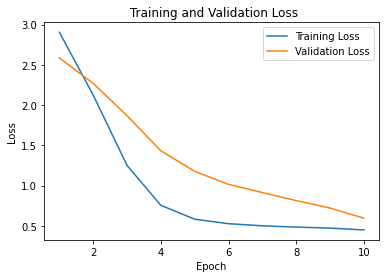

In [ ]:

x = [i for i in range(1,11)]

plt.title(" Training and Validation Loss")
plt.xlabel('Epoch')
plt.ylabel('Loss')

plt.plot(x,t_loss,label='Training Loss')
plt.plot(x,v_loss,label='Validation Loss')

plt.legend()
plt.show()

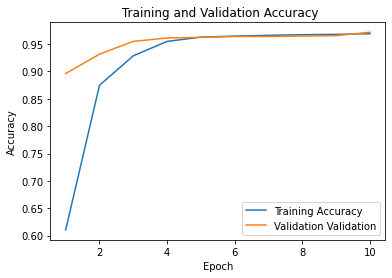

In [ ]:
x = [i for i in range(1,11)]

plt.title(" Training and Validation Accuracy")

plt.xlabel('Epoch')
plt.ylabel('Accuracy')

plt.plot(x,accuracy,label='Training Accuracy')
plt.plot(x,val_accuracy,label='Validation Validation')

plt.legend()
plt.show()

**Evaluating the Model**

To evaluate the model, we will have to remove the padded portion and identify the accuracy. For this, for every test data, let us create a dataframe wuth the tokens and the actual and predicted value - and use it to calculate the metrics

In [ ]:
def evaluatePredictions(test_data,preds,actual_preds):
    print("Shape of Test Data Array",test_data.shape)
    y_actual=np.argmax(np.array(actual_preds),axis=2)
    y_pred=np.argmax(preds,axis=2)
    num_test_data=test_data.shape[0]
    print("Number of Test Data Points ",num_test_data)
    data=pd.DataFrame()
    df_list=[]
    for i in range(num_test_data):
        test_str=list(test_data[i])
        df=pd.DataFrame()
        df['test_tokens']=test_str
        df['tokens']=df['test_tokens'].apply(lambda x:token.index_word[x] if x!=0 else '<PAD>')
        df['actual_target_index']=list(y_actual[i])
        df['pred_target_index']=list(y_pred[i])
        df['actual_target_tag']=df['actual_target_index'].apply(lambda x:reverse_tag_map[x])
        df['pred_target_tag']=df['pred_target_index'].apply(lambda x:reverse_tag_map[x])
        df['id']=i+1
        df_list.append(df)
    data=pd.concat(df_list)
    pred_data=data[data['tokens']!='<PAD>']
    accuracy=pred_data[pred_data['actual_target_tag']==pred_data['pred_target_tag']].shape[0]/pred_data.shape[0]
    
    
    return pred_data,accuracy

In [ ]:
y_pred = model.predict(x_test)

In [ ]:
pred_data,accuracy=evaluatePredictions(x_test,y_pred,y_test)

Shape of Test Data Array (200, 128)
Number of Test Data Points  200


In [ ]:
print("Accuracy on test data is : ",round(accuracy,2))

Accuracy on test data is :  0.79


In [ ]:
y_pred=pred_data['pred_target_tag'].tolist()
y_actual=pred_data['actual_target_tag'].tolist()

In [ ]:
print(classification_report(y_actual,y_pred))

              precision    recall  f1-score   support

    CARDINAL       0.42      0.50      0.46        16
        DATE       0.25      0.48      0.32        52
       EVENT       0.08      0.40      0.14         5
         GPE       0.40      0.68      0.50        31
         LOC       0.60      0.62      0.61        40
       MONEY       0.00      0.00      0.00         4
        NORP       0.24      0.67      0.35         9
           O       0.96      0.82      0.88      3150
     ORDINAL       0.80      0.80      0.80         5
         ORG       0.11      0.40      0.17        80
      PERSON       0.26      0.59      0.36        56
     PRODUCT       0.00      0.00      0.00         6
        TIME       0.21      0.43      0.29         7
 WORK_OF_ART       0.00      0.00      0.00         3

    accuracy                           0.79      3464
   macro avg       0.31      0.46      0.35      3464
weighted avg       0.89      0.79      0.83      3464



In [ ]:
pred_data[pred_data['actual_target_tag']=='LOC']

,test_tokens,tokens,actual_target_index,pred_target_index,actual_target_tag,pred_target_tag,id
5,2,the,8,5,LOC,O,7
6,62,south,8,8,LOC,LOC,7
7,245,atlantic,8,8,LOC,LOC,7
17,2659,hayden,8,5,LOC,O,47
18,1271,lake,8,3,LOC,ORG,47
19,483,idaho,8,3,LOC,ORG,47
5,62,south,8,8,LOC,LOC,49
6,128,georgia,8,8,LOC,LOC,49
7,84,island,8,8,LOC,LOC,49
27,62,south,8,8,LOC,LOC,53


# Bert Based NER Model

In [ ]:
import torch

if torch.cuda.is_available():        
    device = torch.device("cuda")
else:
    device = torch.device("cpu")
    
print(device)

cpu


Tokenization and Input Formatting

In [ ]:
!pip install transformers -U

In [ ]:
import joblib
import torch
import torch.nn as nn
import transformers

import numpy as np
import pandas as pd

from sklearn import preprocessing
from sklearn import model_selection

from tqdm import tqdm
from transformers import AdamW
from transformers import get_linear_schedule_with_warmup

In [ ]:
class config:
    MAX_LEN = 128
    TRAIN_BATCH_SIZE = 32
    VALID_BATCH_SIZE = 8
    EPOCHS = 3
    #BASE_MODEL_PATH = "../input/bert-base-uncased/"
    MODEL_PATH = "model.bin"
    #TRAINING_FILE = "../input/entity-annotated-corpus/ner_dataset.csv"
    TOKENIZER = transformers.BertTokenizer.from_pretrained(
        BASE_MODEL_PATH,
        do_lower_case=True
    )

In [ ]:
MAX_LEN = 128
TRAIN_BATCH_SIZE = 32
VALID_BATCH_SIZE = 8
EPOCHS = 3

In [ ]:
from transformers import BertTokenizer

# Load the BERT tokenizer.
TOKENIZER = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)

In [ ]:
class EntityDataset:
    def __init__(self, texts, tags):
        self.texts = texts
        self.tags = tags
    
    def __len__(self):
        return len(self.texts)
    
    def __getitem__(self, item):
        text = self.texts[item]
        tags = self.tags[item]

        ids = []
        target_tag =[]

        for i, s in enumerate(text):
            inputs = TOKENIZER.encode(
                s,
                add_special_tokens=False
            )

            input_len = len(inputs)
            ids.extend(inputs)
            target_tag.extend([tags[i]] * input_len)

        ids = ids[:MAX_LEN - 2]
        target_tag = target_tag[:MAX_LEN - 2]

        ids = [101] + ids + [102]
        target_tag = [0] + target_tag + [0]

        mask = [1] * len(ids)
        token_type_ids = [0] * len(ids)

        padding_len = MAX_LEN - len(ids)

        ids = ids + ([0] * padding_len)
        mask = mask + ([0] * padding_len)
        token_type_ids = token_type_ids + ([0] * padding_len)
        target_tag = target_tag + ([0] * padding_len)

        return {
            "ids": torch.tensor(ids, dtype=torch.long),
            "mask": torch.tensor(mask, dtype=torch.long),
            "token_type_ids": torch.tensor(token_type_ids, dtype=torch.long),
            "target_tag": torch.tensor(target_tag, dtype=torch.long),
        }

In [ ]:
def train_fn(data_loader, model, optimizer, device, scheduler):
    model.train()
    final_loss = 0
    for data in tqdm(data_loader, total=len(data_loader)):
        for k, v in data.items():
            data[k] = v.to(device)
        optimizer.zero_grad()
        _, _, loss = model(**data)
        loss.backward()
        optimizer.step()
        scheduler.step()
        final_loss += loss.item()
    return final_loss / len(data_loader)


def eval_fn(data_loader, model, device):
    model.eval()
    final_loss = 0
    for data in tqdm(data_loader, total=len(data_loader)):
        for k, v in data.items():
            data[k] = v.to(device)
        _, _, loss = model(**data)
        final_loss += loss.item()
    return final_loss / len(data_loader)

In [ ]:
def loss_fn(output, target, mask, num_labels):
    lfn = nn.CrossEntropyLoss()
    active_loss = mask.view(-1) == 1
    active_logits = output.view(-1, num_labels)
    active_labels = torch.where(
        active_loss,
        target.view(-1),
        torch.tensor(lfn.ignore_index).type_as(target)
    )
    loss = lfn(active_logits, active_labels)
    return loss


class EntityModel(nn.Module):
    def __init__(self, num_tag):
        super(EntityModel, self).__init__()
        self.num_tag = num_tag
        self.bert = transformers.BertModel.from_pretrained(
            config.BASE_MODEL_PATH
        )
        self.bert_drop_1 = nn.Dropout(0.3)
        self.bert_drop_2 = nn.Dropout(0.3)
        self.out_tag = nn.Linear(768, self.num_tag)
        self.out_pos = nn.Linear(768, self.num_pos)
    
    def forward(
        self, 
        ids, 
        mask, 
        token_type_ids, 
        target_pos, 
        target_tag
    ):
        o1, _ = self.bert(
            ids, 
            attention_mask=mask, 
            token_type_ids=token_type_ids
        )

        bo_tag = self.bert_drop_1(o1)
        bo_pos = self.bert_drop_2(o1)

        tag = self.out_tag(bo_tag)
        pos = self.out_pos(bo_pos)

        loss_tag = loss_fn(tag, target_tag, mask, self.num_tag)
        loss_pos = loss_fn(pos, target_pos, mask, self.num_pos)

        loss = (loss_tag + loss_pos) / 2

        return tag, pos, loss